# Model gene expression trends ~ distance + area + distance:area to closest cyst all together

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import scanpy as sc
import scanpy.external as sce
from pygam import GAM, s
from scipy.ndimage import convolve
import collections
from concurrent.futures import ThreadPoolExecutor
import anndata as ad
from typing import Optional
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import gaussian_kde
from tqdm.notebook import tqdm

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [3]:
pkd_1 = sc.read_h5ad(f"/exports/humgen/cnovellarausell/SevtapSpatial/pkd_1_visium_with_distances_and_areas.h5ad")
pkd_2 = sc.read_h5ad(f"/exports/humgen/cnovellarausell/SevtapSpatial/pkd_2_visium_with_distances_and_areas.h5ad")
pkd_3 = sc.read_h5ad(f"/exports/humgen/cnovellarausell/SevtapSpatial/pkd_3_visium_with_distances_and_areas.h5ad")

In [4]:
adata = pkd_1.concatenate([pkd_2, pkd_3])

<Axes: xlabel='closest_cyst_distance', ylabel='Count'>

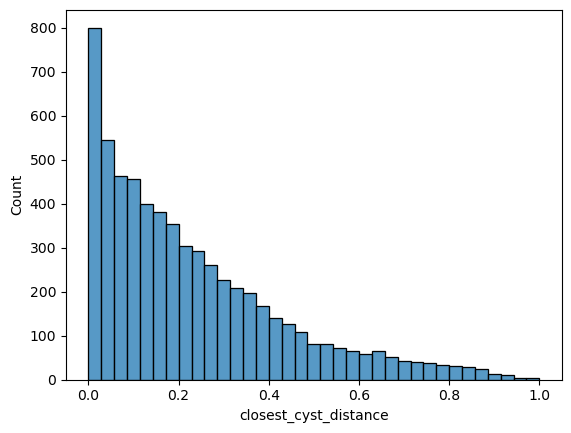

In [12]:
sns.histplot(adata.obs['closest_cyst_distance'])

In [6]:
adata

AnnData object with n_obs × n_vars = 6277 × 17628
    obs: 'in_tissue', 'array_row', 'array_col', 'library_id', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_hb', 'pct_counts_hb', 'total_counts_ribo', 'pct_counts_ribo', 'n_counts', 'clusters', 'clusters_0.7', 'S_score', 'G2M_score', 'phase', 'cell_types', 'closest_cyst_distance', 'closest_cyst_area', 'batch'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'hb', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    obsm: 'X_pca', 'X_umap', 'spatial'
    layers: 'LogNorm', 'scaled'

In [7]:
adata = adata[np.isfinite(adata.obs.closest_cyst_distance.values)].copy()

In [8]:
adata

AnnData object with n_obs × n_vars = 6162 × 17628
    obs: 'in_tissue', 'array_row', 'array_col', 'library_id', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_hb', 'pct_counts_hb', 'total_counts_ribo', 'pct_counts_ribo', 'n_counts', 'clusters', 'clusters_0.7', 'S_score', 'G2M_score', 'phase', 'cell_types', 'closest_cyst_distance', 'closest_cyst_area', 'batch'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'hb', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    obsm: 'X_pca', 'X_umap', 'spatial'
    layers: 'LogNorm', 'scaled'

In [9]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [10]:
scaler = MinMaxScaler()
scaler.fit(adata.obs.closest_cyst_distance.values.reshape(-1,1))
adata.obs.closest_cyst_distance = scaler.transform(adata.obs.closest_cyst_distance.values.reshape(-1,1))

In [11]:
scaler = MinMaxScaler()
scaler.fit(adata.obs.closest_cyst_area.values.reshape(-1,1))
adata.obs.closest_cyst_area = scaler.transform(adata.obs.closest_cyst_area.values.reshape(-1,1))

In [13]:
models = {}
y_test_dict = {}
x_test_dict = {}

# Define two smooth terms for our 2D GAM
terms = (
    s(0, spline_order=3, n_splines=6, lam=3, penalties=['derivative', 'l2']) +  # distance
    s(1, spline_order=3, n_splines=6, lam=3, penalties=['derivative', 'l2'])   # area
)

# Create progress bar with descriptive information
pbar = tqdm(
    adata.var_names,
    desc="Fitting GAM models",
    unit="gene",
    total=len(adata.var_names),
    bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} genes [{elapsed}<{remaining}]'
)

for gene in pbar:
    pbar.set_description(f"Processing {gene}")
    
    gam = GAM(terms=terms, distribution='normal', link='log', max_iter=2000)
    
    # Prepare response variable (gene expression)
    y = adata[:, gene].X.A.reshape((adata.shape[0], 1))
    
    # Prepare predictor variables
    x_dist = adata.obs['closest_cyst_distance'].values
    x_area = adata.obs['closest_cyst_area'].values
    x_dist = x_dist.reshape((len(x_dist), 1))
    x_area = x_area.reshape((len(x_area), 1))
    X = np.column_stack([x_dist, x_area])
    
    w = np.ones(len(x_dist))
    w = w.reshape((len(w), 1))
    
    gam.gridsearch(X=X, y=y, progress=False)
    model = gam.fit(X, y)
    
    # Generate test points for distance (linear spacing)
    dist_start = np.min(x_dist)
    threshold = np.nanmedian(w)
    w_test = w[w >= threshold]
    n_window = 200 // 20
    tmp = convolve(w_test, np.ones(n_window) / n_window, mode="nearest")
    dist_end = x_dist[w >= threshold][-1]
    
    if dist_start > dist_end:
        dist_start, dist_end = dist_end, dist_start
    
    dist_start, dist_end = (max(dist_start, np.min(x_dist)), max(dist_end, np.max(x_dist)))
    x_test_dist = np.linspace(dist_start, dist_end, 200)
    
    # Generate test points for area (density-based sampling)
    kde_area = gaussian_kde(x_area.ravel())
    area_candidates = np.linspace(np.min(x_area), np.max(x_area), 1000)
    area_densities = kde_area.evaluate(area_candidates)
    x_test_area = np.random.choice(
        area_candidates,
        size=200,
        p=area_densities/area_densities.sum(),
        replace=False
    )
    x_test_area.sort()  # Sort for smoother visualization
    
    # Create 2D prediction grid
    X1, X2 = np.meshgrid(x_test_dist, x_test_area)
    X_test = np.column_stack([X1.ravel(), X2.ravel()])
    
    # Generate predictions
    y_test = gam.predict(X_test)
    y_test = y_test.reshape(X1.shape)
    
    # Store results
    models[gene] = gam
    x_test_dict[gene] = {
        'distance': x_test_dist,
        'area': x_test_area
    }
    y_test_dict[gene] = y_test

pbar.close()

Fitting GAM models:   0%|          | 0/17628 genes [00:00<?]

In [ ]:
y_test_dict

In [16]:
import pickle

with open('/exports/humgen/cnovellarausell/SevtapSpatial/Trained_models_max_distance_and_area_all_kidneys.pkl', 'wb') as handle:
    pickle.dump(models, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('/exports/humgen/cnovellarausell/SevtapSpatial/Trained_mdodels_predictions_max_distance_and_area_all_kidneys.pkl', 'wb') as handle:
    pickle.dump(y_test_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('/exports/humgen/cnovellarausell/SevtapSpatial/Trained_mdodels_x_test_max_distance_and_area_all_kidneys.pkl', 'wb') as handle:
    pickle.dump(x_test_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)